# Problem Set 2 -- Sampling-based algorithms in Gen

<div class="alert alert-info">
    
**Instructions:** Finish the code following the instructions. Execute all blocks of your Jupyter notebook, write analyses in English in the corresponding Markdown blocks ("marked as YOUR ANSWER HERE"), save the final notebook as a pdf file, and submit it on Canvas.

Acknowledge the contributions if you collaborated with someone else. You must write your own code and analyses.
</div>

First, let's install neccessary packages.

#### Contributors: TJ Bai

In [1]:
import Pkg
Pkg.activate("CogAI")
Pkg.add(["CSV", "DataFrames"])
# load necessary packages for this problem set
# Note that running this for the first time might take a good 15 mins &ndash; plan ahead
using Gen
using Plots
using CSV
using DataFrames

include("utils/draw.jl")

  Activating project at `~/Library/CloudStorage/OneDrive-JohnsHopkins/Documents/JHU/jhu-2024-spring/cog-ai/ps2/CogAI`
   Resolving package versions...
  No Changes to `~/Library/CloudStorage/OneDrive-JohnsHopkins/Documents/JHU/jhu-2024-spring/cog-ai/ps2/CogAI/Project.toml`
  No Changes to `~/Library/CloudStorage/OneDrive-JohnsHopkins/Documents/JHU/jhu-2024-spring/cog-ai/ps2/CogAI/Manifest.toml`


has_argument_grads (generic function with 33 methods)

## Question 1

Nimet has been inspecting 3 colonies of leaf bugs; the average size of the members of each colony is different and denoted as $\theta_1, \theta_2, \theta_3$. 

Nimet knows that these 3 colonies are related, sprung off from a common colony last year: That is, she believes the average size of leafbugs in each colony should come from a shared underlying distribution. 

She measures the size of the 40 members of each colony, denoted $\vec{x}_1, \vec{x}_2, \vec{x}_3$. 

Nimet intuitively arrives at an inference about the average size of the members of each colony, as well as the shared parameter determining the average size of  leafbugs in each colony, based on these observations from each colony.

Your task is to formalize Nimet's inference process. You can assume that the average size of leafbugs in a colony (i.e., $\theta$s) can be modeled as coming from a Gamma distribution, $Gamma(\alpha, scale=2)$, shared across the three colonies. Furthermore, you can assume a prior over the `shape` parameter of the Gamma distribution, denoted $\alpha$, to be a uniform over the range of 1.0 to 15.0. (We assume that we know the scale parameter of the Gamma distribution `scale=2`).

Finally assume that the size measurements come from a normal distribution with known standard deviation $\vec{x}_{i,k} \sim Normal(\theta_i, \sigma=0.1)$, where $i \in [1, 3]$ indexes the colony and $k \in [1, 40]$ indexes members in that colony.

The following shows a graphical model of the generative model you can use to formalize Nimet's thought process. 

<img src="./images/leafbug-gm.png" alt="" width="400"/>

### Q 1A [3 pts]

Fill in the following to write a Gen generative function of the prior illustrated in the graphical model based on the parametric distributions you decided appropriate.

In [2]:
@gen function leafbug_colonies()
    scale = 2
    σ = 0.1

    α = ({:α} ~ uniform(1, 15))
    
    theta_one = ({:theta_one} ~ gamma(α, scale))
    theta_two = ({:theta_two} ~ gamma(α, scale))
    theta_three = ({:theta_three} ~ gamma(α, scale))
    thetas = (theta_one, theta_two, theta_three)

    for colony_id in 1:3
        for leafbug_id in 1:40
            {:data => colony_id => leafbug_id => :x} ~ normal(thetas[colony_id], σ)
        end
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##leafbug_colonies#225", Bool[], false)

Now simulate your generative function to ensure that its outputs make sense

In [3]:
# Run your model `leafbug_colonies` forward
trace = simulate(leafbug_colonies, ())
get_choices(trace)

│
├── :α : 6.386116539910839
│
├── :theta_three : 15.27273386851144
│
├── :theta_two : 7.9929045427673335
│
├── :theta_one : 9.355240602906914
│
└── :data
    │
    ├── 2
    │   │
    │   ├── 5
    │   │   │
    │   │   └── :x : 8.180896127749454
    │   │
    │   ├── 16
    │   │   │
    │   │   └── :x : 7.9105838826210055
    │   │
    │   ├── 20
    │   │   │
    │   │   └── :x : 8.018554038873079
    │   │
    │   ├── 35
    │   │   │
    │   │   └── :x : 8.10318315733256
    │   │
    │   ├── 12
    │   │   │
    │   │   └── :x : 7.873158302696361
    │   │
    │   ├── 24
    │   │   │
    │   │   └── :x : 8.110541453802895
    │   │
    │   ├── 28
    │   │   │
    │   │   └── :x : 7.938759706829921
    │   │
    │   ├── 8
    │   │   │
    │   │   └── :x : 7.958813554981893
    │   │
    │   ├── 17
    │   │   │
    │   │   └── :x : 8.019167773967068
    │   │
    │   ├── 30
    │   │   │
    │   │   └── :x : 8.10815457457524
    │   │
    │   ├── 1
    │   │   │
    │   │   └─

Fill in the following code to load your data from `./data/leafbug_sizes.csv`. Each column is measurements in a colony.

In [4]:
function make_observations(df::DataFrame)
    constraints = choicemap()

    for colony_id in 1:3
        column = df[!, "colony$colony_id"]
        for leafbug_id in 1:40
            constraints[:data => colony_id => leafbug_id => :x] = column[leafbug_id]
        end
    end
    constraints
end 

df = DataFrame(CSV.File("./data/leafbug_sizes.csv"))
observations = make_observations(df)

│
└── :data
    │
    ├── 2
    │   │
    │   ├── 5
    │   │   │
    │   │   └── :x : 21.256299943303237
    │   │
    │   ├── 16
    │   │   │
    │   │   └── :x : 21.369553855546922
    │   │
    │   ├── 20
    │   │   │
    │   │   └── :x : 21.251178256760287
    │   │
    │   ├── 35
    │   │   │
    │   │   └── :x : 21.13898163338359
    │   │
    │   ├── 12
    │   │   │
    │   │   └── :x : 21.206757582334074
    │   │
    │   ├── 24
    │   │   │
    │   │   └── :x : 21.305648418588138
    │   │
    │   ├── 28
    │   │   │
    │   │   └── :x : 21.124249614774968
    │   │
    │   ├── 8
    │   │   │
    │   │   └── :x : 21.270571265316352
    │   │
    │   ├── 17
    │   │   │
    │   │   └── :x : 21.15103714447646
    │   │
    │   ├── 30
    │   │   │
    │   │   └── :x : 21.242026934969317
    │   │
    │   ├── 1
    │   │   │
    │   │   └── :x : 21.280550797233133
    │   │
    │   ├── 19
    │   │   │
    │   │   └── :x : 21.167870648339825
    │   │
    │   ├── 22
    

### Q 1B [1 pt]

Given your generative model and observations, we will perform importance resampling for posterior inference. Fill in the code to obtain 100 posterior samples each using 1000 resampling steps.

In [5]:
traces = Vector()
for _ in 1:100
    (trace, _) = importance_resampling(leafbug_colonies, (), observations, 1000)
    push!(traces, trace)
end

### Q 1C [1 pts]

Fill in the following codeblock to visualize your posterior samples. 

First, show the mean log probability of all traces

Then make a plot with 2 subplots

* Subplot 1: Make a histogram plot showing $\alpha$.
* Subplot 2: Make another histogram plot showing the three $\theta$s on the same plot.

In [6]:
# function for compute the average log probs of all traces
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

# function for display all traces
function display_results(traces)
    # compute the average log prob of all traces
    log_probs = [get_score(t) for t in traces]
    println("Average log probability: $(logmeanexp(log_probs))")

    # collect the inferred αs and θs across the chains and plot them.
    αs = [t[:α] for t in traces]
    theta_ones = [t[:theta_one] for t in traces]
    theta_twos = [t[:theta_two] for t in traces]
    theta_threes = [t[:theta_three] for t in traces]

    # plot the movements
    α_plot = histogram(αs, thickness_scaling=3.5, size=(1000, 800), label="α", xtickfontsize=5, ytickfontsize=5)
    theta_ones_plot = histogram(theta_ones, thickness_scaling=3.5, size=(300, 800), label="theta1", xtickfontsize=5, ytickfontsize=5)
    theta_twos_plot = histogram(theta_twos, thickness_scaling=3.5, size=(300, 800), label="theta2", xtickfontsize=5, ytickfontsize=5)
    theta_threes_plot = histogram(theta_threes, thickness_scaling=3.5, size=(300, 800), label="theta3", xtickfontsize=5, ytickfontsize=5)
    θ_plot = plot(theta_ones_plot, theta_twos_plot, theta_threes_plot, layout=(1, 3), size=(1000, 800), xtickfontsize=5, ytickfontsize=5)
    
    plot(α_plot, θ_plot, layout=(2, 1), size=(1600, 1200))
end;

Average log probability: -5.428575652848323


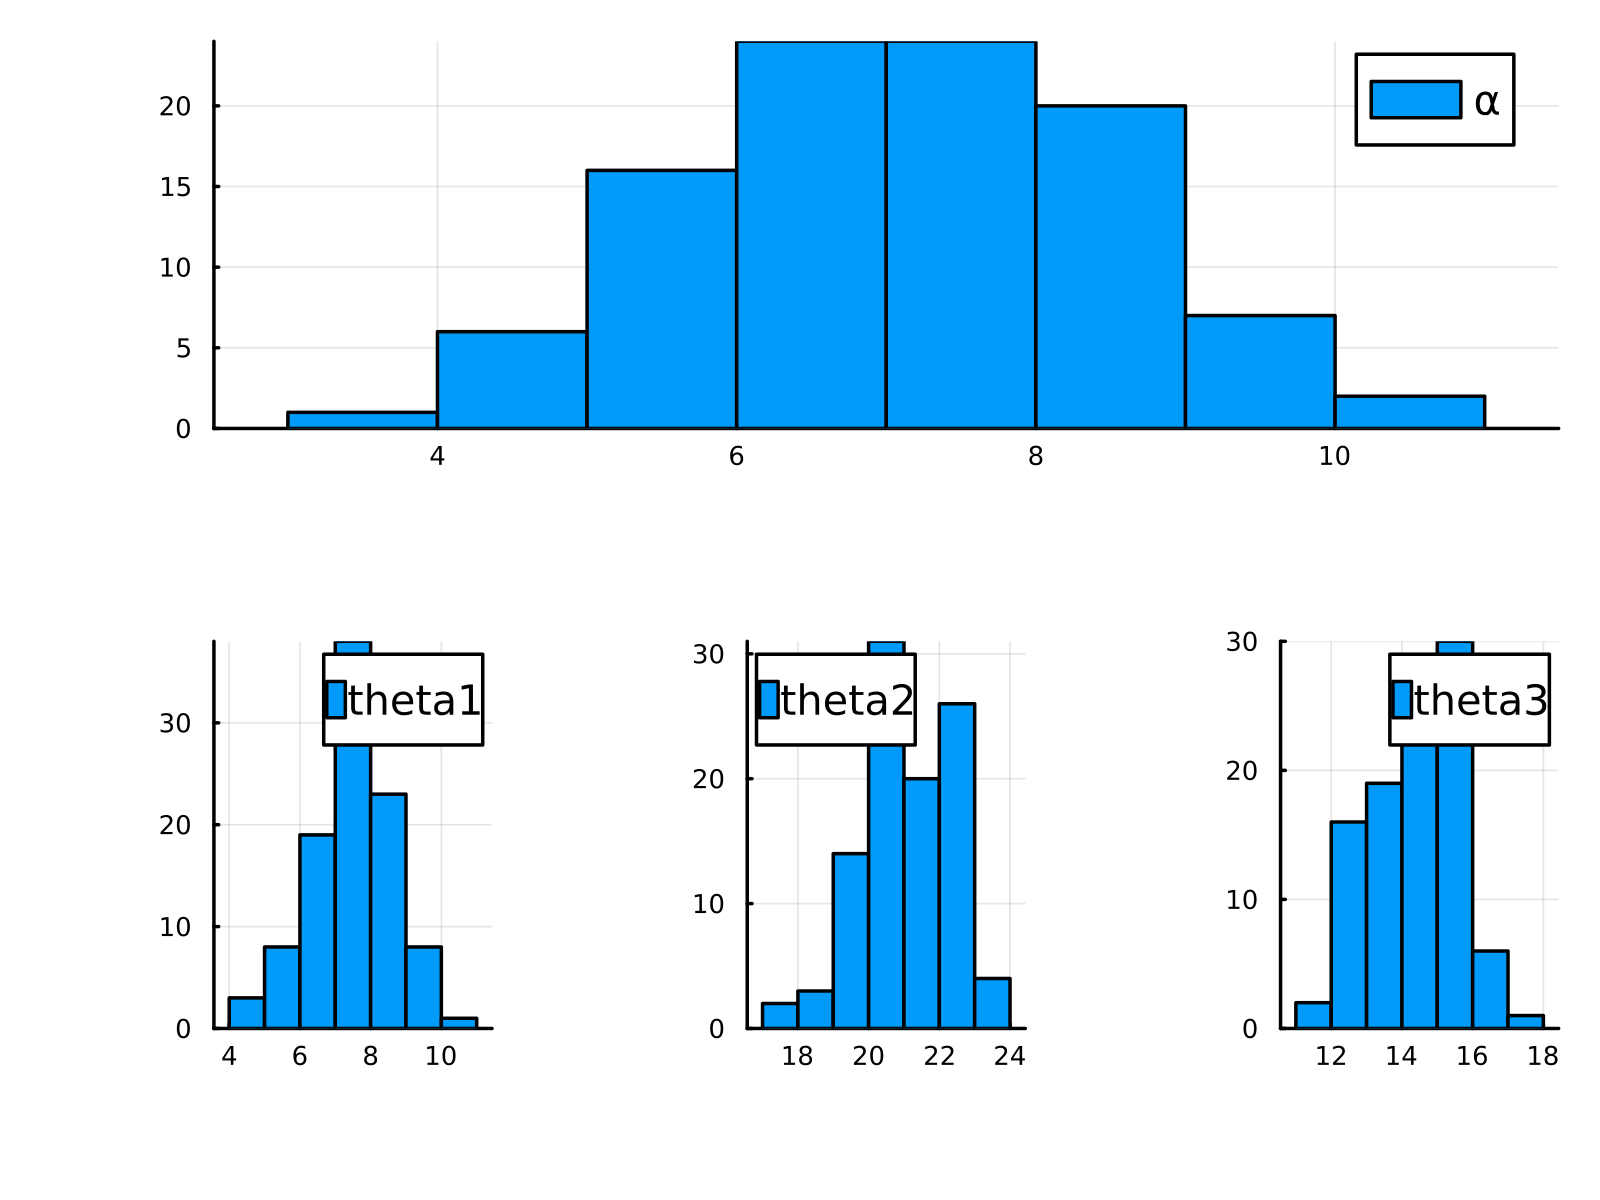

In [7]:
# run the display_results function to show the average log prob and inferred variables
# your code here
display_results(traces)

### Q 1D [3 pts]

Now let's implement a MCMC algorithm with a cutomized proposal. In particular,

1. Random work proposal for α 
2. Then block resimulation for θs

Expected result: with 1000 updates (similar amount of compute compared to importance resampling), the mean log prob should be at least around 100

You need to tune the max step size in random walk proposal to reach good inference results.


In [8]:
@gen function random_walk_proposal(current_trace)
    step_size = 3
    α ~ uniform(max(current_trace[:α] - step_size, 1), min(current_trace[:α] + step_size, 15))
end;

In [9]:
function MCMC_inference(observations, num_updates)
    (tr, _) = generate(leafbug_colonies, (), observations)
    
    for iter_id = 1:num_updates
        # random walk MH update for α
        (tr, _) = mh(tr, random_walk_proposal, ())
            
        # block resimulation MN update for θs
        (tr, _) = mh(tr, Gen.select(:theta_one))
        (tr, _) = mh(tr, Gen.select(:theta_two))
        (tr, _) = mh(tr, Gen.select(:theta_three))
    end
    tr
end;

### Q 1E [1 pt]

Fill in the code to obtain 100 posterior samples each using 1000 MH updates; then display the results using the display_results() function.

In [10]:
# Note: this codeblock might take a while to run
traces = Vector()
for _ in 1:100
    push!(traces, MCMC_inference(observations, 1000))
end

Average log probability: 89.68495605512602


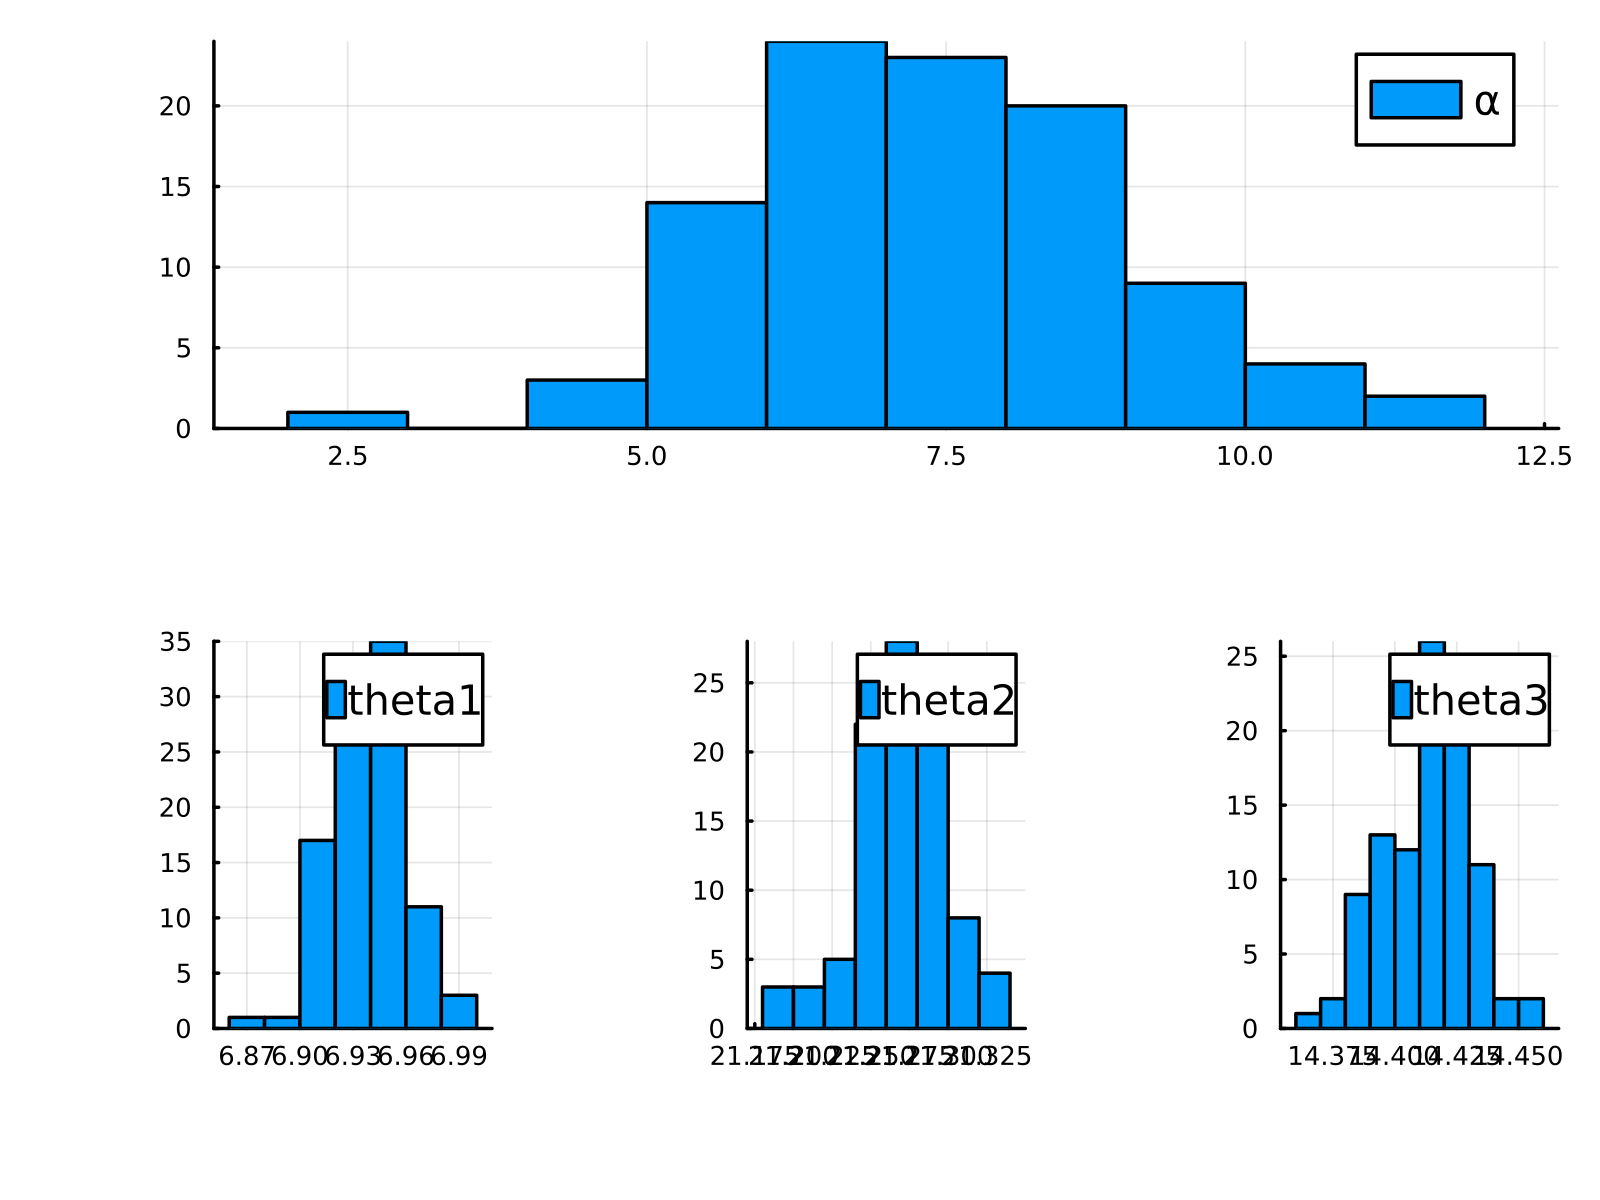

In [11]:
display_results(traces)

### Q 1F [1 pt]
Compare the results of MCMC and importance resampling. Briefly explain the difference. Write 1 - 2 sentences in the Markdown block below.

Based on the importance sampling histogram, the distributions of theta and alpha have more variance and potential outliers. MCMC sampling is signifcantly better because of the random-walk proposal, which is more informed than random sampling, and block resimulation, which improves resimulation since we only sample a subset of the distribution. 

## Question 2

The iron core of our planet conducts electricity, which creates a magnetic field around Earth. This magnetic field not only provides a protective shield against sun’s unwanted rays, but also creates a kind of a map that remains relatively constant across time. Many animal species are thought to rely on this magnetic field for wayfinding, from migratory birds across the open skies to fish, reptiles and crustaceans in the deep ocean. For example, sea turtles can use the magnetic field to make plans between points A and B on the globe, and to orient themselves, i.e., to know where they are on the Earth. 

Let's assume that the planet's magnetic field can be described using a two-dimensional grid. The sea turtle moves in this gridworld one step at a time, in one of the four cardinal direction: north (n), south (s), east (e), and west (w). The following struct encodes these mechanics of grid movements and it will come handy as we go along.



In [12]:
struct Movement
    dx::Real
    dy::Real
end

const N = Movement( 0,  1)
const E = Movement( 1,  0)
const S = Movement( 0, -1)
const W = Movement(-1,  0)
const DIRECTIONS = [N, S, E, W]

4-element Vector{Movement}:
 Movement(0, 1)
 Movement(0, -1)
 Movement(1, 0)
 Movement(-1, 0)

Each cell in this grid emits the *intensity* and *direction* of the magnetic field at that cell. The `intensity` and `direction` of a coordinate at `x` and `y` are defined as:

<img src="./images/magnetic-field.png" alt="" width="400"/>

Your overall goal in this question will be to infer a posterior over the sequence of movements of the sea turtle from a sequence of intensity and direction observations. We will build up to that.

### Q 2A [4 pts]

Imagine that suddently, this sea turtle finds itself in the middle of an oceanic storm. The storm is such that:

* The sea turtle knows where it is at the beginning of the storm (time step `k=0`), including its `x` and `y` 
* At each time step, its movement &ndash; a single step in a cardinal direction: north `n`, south `s`, east `e` or west `w` &ndash; are dictated by the waves and turbulence of the ocean (not controlled by the sea turtle). Assume that these dynamics are random &ndash; a multinomial distribution with equal weight on each direction:

$$p(m_{t} | m_{t-1}) = p(m_{t}) = Multinomial([n, s, e, w])$$

* At each time step, the sea turtle observes noisy magnetic field measurements (because of the storm, it cannot additionally rely on vision or smell) 
$$p(intensity_{t}) \sim Normal(x + y, \sigma)$$
$$p(direction_{t}) \sim Normal(|x-y|, \sigma)$$
where $\sigma=0.1$

(You might be able to relate to the experience of our sea turtle friend if you can remember the last time you were on a Ferris Wheel with your eyes closed. In such a scenario, when you rely just on your vestibular system to tell your pose in space, you are likely to experience all sorts of hallucinated backward flips.)

Your task is write a generative model of this process using Gen's generative functions and the generative function combinator `Unfold`. You will write a generative function (a temporal kernel) called `ferriswheel_kernel`, and input it to the `Unfold` combinator to create a temporal generative model called `ferriswheel`. 

Assume that the initial state of the sea turtle is provided to `ferriswheel` as a global variable (not modeled as a random variable). 

Start with implementing a Julia `struct` to represent and modify the state information at each time step; the struct should include the following three entities. (For each variable, you must indicate its type.)

- `movement`: current movement
- `x`: current coordinate in the east-west axis
- `y`: current coordinate in the north-south axis

In [13]:
struct Field
    movement::Movement
    x::Real
    y::Real
end

Using the definitions above, fill in the following `intensity` function to compute the intensity of a `Field`.

In [14]:
function intensity(field::Field)
    field.x + field.y
end

intensity (generic function with 1 method)

Using the definitions above, fill in the following `direction` function to compute the direction of a `Field`.

In [15]:
function direction(field::Field)
   abs(field.x - field.y)
end

direction (generic function with 1 method)

We need a way to update the `x` and `y` entries of a `Field` based on a `Movement`. Using Julia's support for multiple dispatch and overriding functions and primitives, we provide a redefined addition, `Base.:+`, which applies a `Movement` to the `x` and `y` entries of a Field, returning a new `Field` with the addition as well as the input `Movement`. This will come in handy as we go along.

In [16]:
function Base.:+(field::Field, movement::Movement)
    return Field(
        movement,
        field.x + movement.dx,
        field.y + movement.dy,
    )
end

Fill in the following code block to complete the definition of ferrishweel_kernel and create a function called chain using Gen's Unfold combinator and this kernel.

In [17]:
@gen function ferriswheel_kernel(k::Int, curr_field::Field)
    # observation noise of the mangetic field (intensity and direction)
    σ = 0.1
    
    # Draw a movement
    draw_move = {:draw_move} ~ categorical([0.25, 0.25, 0.25, 0.25])
    movement = DIRECTIONS[draw_move]

    next_field = curr_field + movement

    # observe noisy intensity/direction measurements
    {:obs_intensity} ~ normal(intensity(next_field), σ)
    {:obs_direction} ~ normal(direction(next_field), σ)
    
    # Return the updated field
    next_field
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Field], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##ferriswheel_kernel#235", Bool[0, 0], false)

Fill in the following codeblock to create the temporal generative model `ferrishweel`

In [26]:
@gen function ferriswheel(K::Int)
    global init_field
    trajectory ~ Unfold(ferriswheel_kernel)(K, init_field)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64], false, Union{Nothing, Some{Any}}[nothing], var"##ferriswheel#240", Bool[0], false)

### Q 1B [1 pt]

Draw a sequence of 10 movements from your generative model. The initial state is provided (`init_field`). 

Use the `get_choices` and `get_retval` functions to display the random choices and return values associated with the trace you simulated of the generative function. 

In [27]:
# Start at coordinates (N, 3, 3)
init_field = Field(N, 3, 3)

# Run your model forward with 10 movements, name your variable `trace`
# your code here
trace = simulate(ferriswheel, (10,))

# Display the choices from `trace`
# your code here
get_choices(trace)

│
└── :trajectory
    │
    ├── 1
    │   │
    │   ├── :obs_direction : 0.9961282863727762
    │   │
    │   ├── :obs_intensity : 5.190624166012839
    │   │
    │   └── :draw_move : 2
    │
    ├── 2
    │   │
    │   ├── :obs_direction : 1.9838404282239697
    │   │
    │   ├── :obs_intensity : 5.795375316313746
    │   │
    │   └── :draw_move : 3
    │
    ├── 3
    │   │
    │   ├── :obs_direction : 1.0773478469578643
    │   │
    │   ├── :obs_intensity : 6.979425356421778
    │   │
    │   └── :draw_move : 1
    │
    ├── 4
    │   │
    │   ├── :obs_direction : -0.027733728666021435
    │   │
    │   ├── :obs_intensity : 7.941599992449401
    │   │
    │   └── :draw_move : 1
    │
    ├── 5
    │   │
    │   ├── :obs_direction : 1.1839059027905325
    │   │
    │   ├── :obs_intensity : 8.974514568849838
    │   │
    │   └── :draw_move : 3
    │
    ├── 6
    │   │
    │   ├── :obs_direction : -0.04260893163201411
    │   │
    │   ├── :obs_intensity : 7.971313862182246
    │ 

In [28]:
# Get the return values for your `trace
# your code here
get_retval(trace)

Persistent{Any}[Field(Movement(0, -1), 3, 2), Field(Movement(1, 0), 4, 2), Field(Movement(0, 1), 4, 3), Field(Movement(0, 1), 4, 4), Field(Movement(1, 0), 5, 4), Field(Movement(-1, 0), 4, 4), Field(Movement(0, 1), 4, 5), Field(Movement(1, 0), 5, 5), Field(Movement(0, -1), 5, 4), Field(Movement(0, 1), 5, 5)]

Execute the next code block to visualize your sample. (Review this visualization code, but nothing to fill in.) You will see that it plots a binary heatmap of which movements occured (n, s, e, w), a gray scale heatmap showing the trajectory, and a line plot of how intensities and directions changed throughout the sequence. 

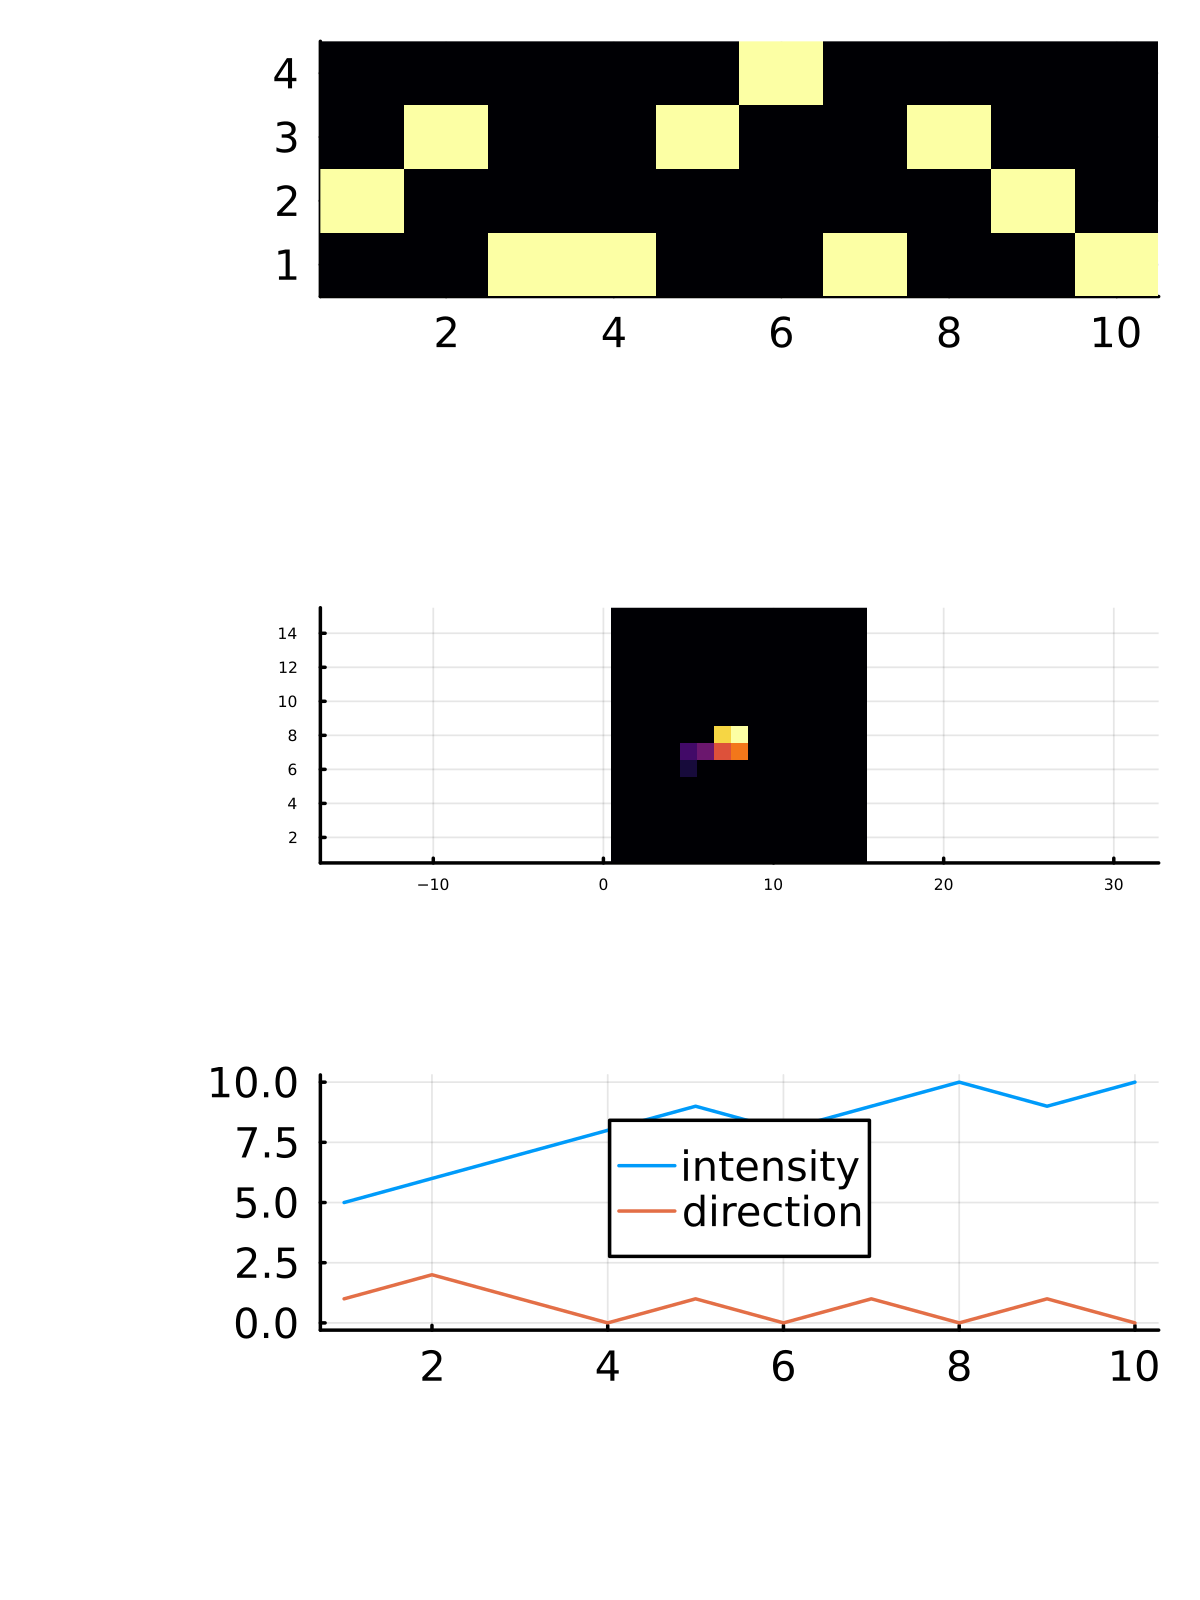

In [29]:
# a helper function to visualize things
# we visualize the movements and 
#   the predicted intensity and direction
#   values according to the coordinates of 
#   visited cells
function visualize(trace; title="")
    choices = get_choices(trace)
    fields  = get_retval(trace)

    # get the movements and coordinates
    ms = [field.movement for field in fields]
    xs = [field.x for field in fields]
    ys = [field.y for field in fields]
    
    # predicted intensities
    intensities = intensity.(fields)
    
    # predicted directions
    directions = direction.(fields)

    # create a binary matrix of movements (4 x length(ms))
    binary_movements = falses(4, length(ms))
    for (index, movement) in enumerate(ms)
        movement_order = findfirst(isequal(movement), DIRECTIONS)
        binary_movements[movement_order, index] = true
    end

    # create a gray scale matrix of coordinates, [-2, 12] x [-2, 12]
    # the brighter the color, the more recent the step is
    binary_coordinates = zeros(15, 15)
    n = length(xs)
    for t = 1:n
        binary_coordinates[xs[t] + 3, ys[t] + 3] = t / n
    end

    # plot the movements
    p1 = plot(
        binary_movements,
        seriestype=:heatmap,
        legend=false, 
        thickness_scaling=3.5,
        title=title,
        titlefont=5,
    )
    p2 = plot(
        binary_coordinates,
        seriestype=:heatmap,
        legend=false, 
        thickness_scaling=3.5,
        aspect_ratio = :equal,
        size=(800, 800),
        xtickfontsize=3,
        ytickfontsize=3,
    )
    # plot intensities and directions
    p3 = plot(
        collect(1:length(ms)),
        [intensities, directions], 
        thickness_scaling=3.5,
        labels=["intensity" "direction"]
    )
    plot(p1, p2, p3, layout=(3,1), legend=:inside, size=(1200, 1600))
end

visualize(trace)

Execute the following codeblock to load and visualize the observed intensity and directions

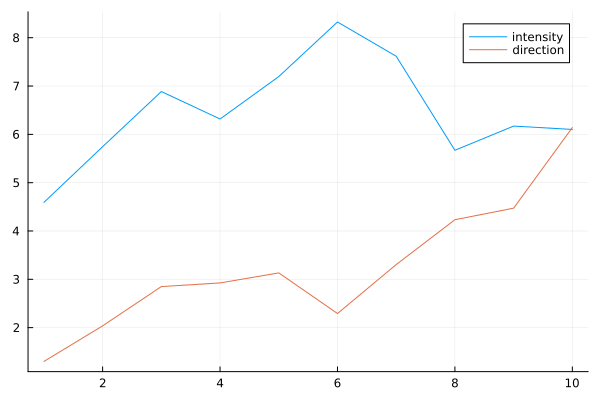

In [30]:
# load observations (sensory features)
obs_fields = DataFrame(CSV.File("./data/observed_fields.csv"))

# visualize (just run the following code)
plot(
    collect(1:size(obs_fields, 1)),
    [obs_fields[!, :intensity], obs_fields[!, :direction]],
    labels=["intensity" "direction"]
)

### Q 1C [4 pts]

In Gen, write a particle filtering algorithm to infer a posterior distribution over movements given the intensity and direction measurements in `observations`.

In [31]:
function particle_filter(num_particles::Int, obs_fields, num_samples::Int)
    #initital observation
    init_obs = choicemap(
        (:trajectory => 0 => :obs_intensity, obs_fields[1, :intensity]),
        (:trajectory => 0 => :obs_direction, obs_fields[1, :direction]),
    )
    
   state = initialize_particle_filter(ferriswheel, (0,), init_obs, num_particles)
        
    for (idx, obs_field) in enumerate(eachrow(obs_fields))
        # Resample
        maybe_resample!(state, ess_threshold=num_particles/2)

        # load observations of this time step
        obs = choicemap(
            (:trajectory => idx => :obs_intensity, obs_field[:intensity]),
            (:trajectory => idx => :obs_direction, obs_field[:direction]),
        )

        # Re-weight by the likelihood 
        particle_filter_step!(state, (idx,), (UnknownChange(),), obs)
    end
    
    return sample_unweighted_traces(state, num_samples)
end

particle_filter (generic function with 1 method)

Now call this particle filter inference procedure with 1000 particles and return 100 samples

In [32]:
pf_traces = particle_filter(1000, obs_fields, 100);

### Q 1D [1 pts]

The following codeblock visualizes these 100 posterior samples you just computer, one after the other; each frame shows the inferred sequence of movements and trajectory according to the posterior sample (top) and the predicted intensities and directions. View this animation and explain what it reveals about the posterior distribution. Write 1-2 sentences in the Markdown block after the animation.

┌ Info: Saved animation to /var/folders/kl/wbnrhqz91z3ccc0kctsjcbvh0000gn/T/jl_xAPoDo7IJ0.gif
└ @ Plots /Users/avnukala/.julia/packages/Plots/a3u1v/src/animation.jl:156


Plots.AnimatedGif("/var/folders/kl/wbnrhqz91z3ccc0kctsjcbvh0000gn/T/jl_xAPoDo7IJ0.gif")
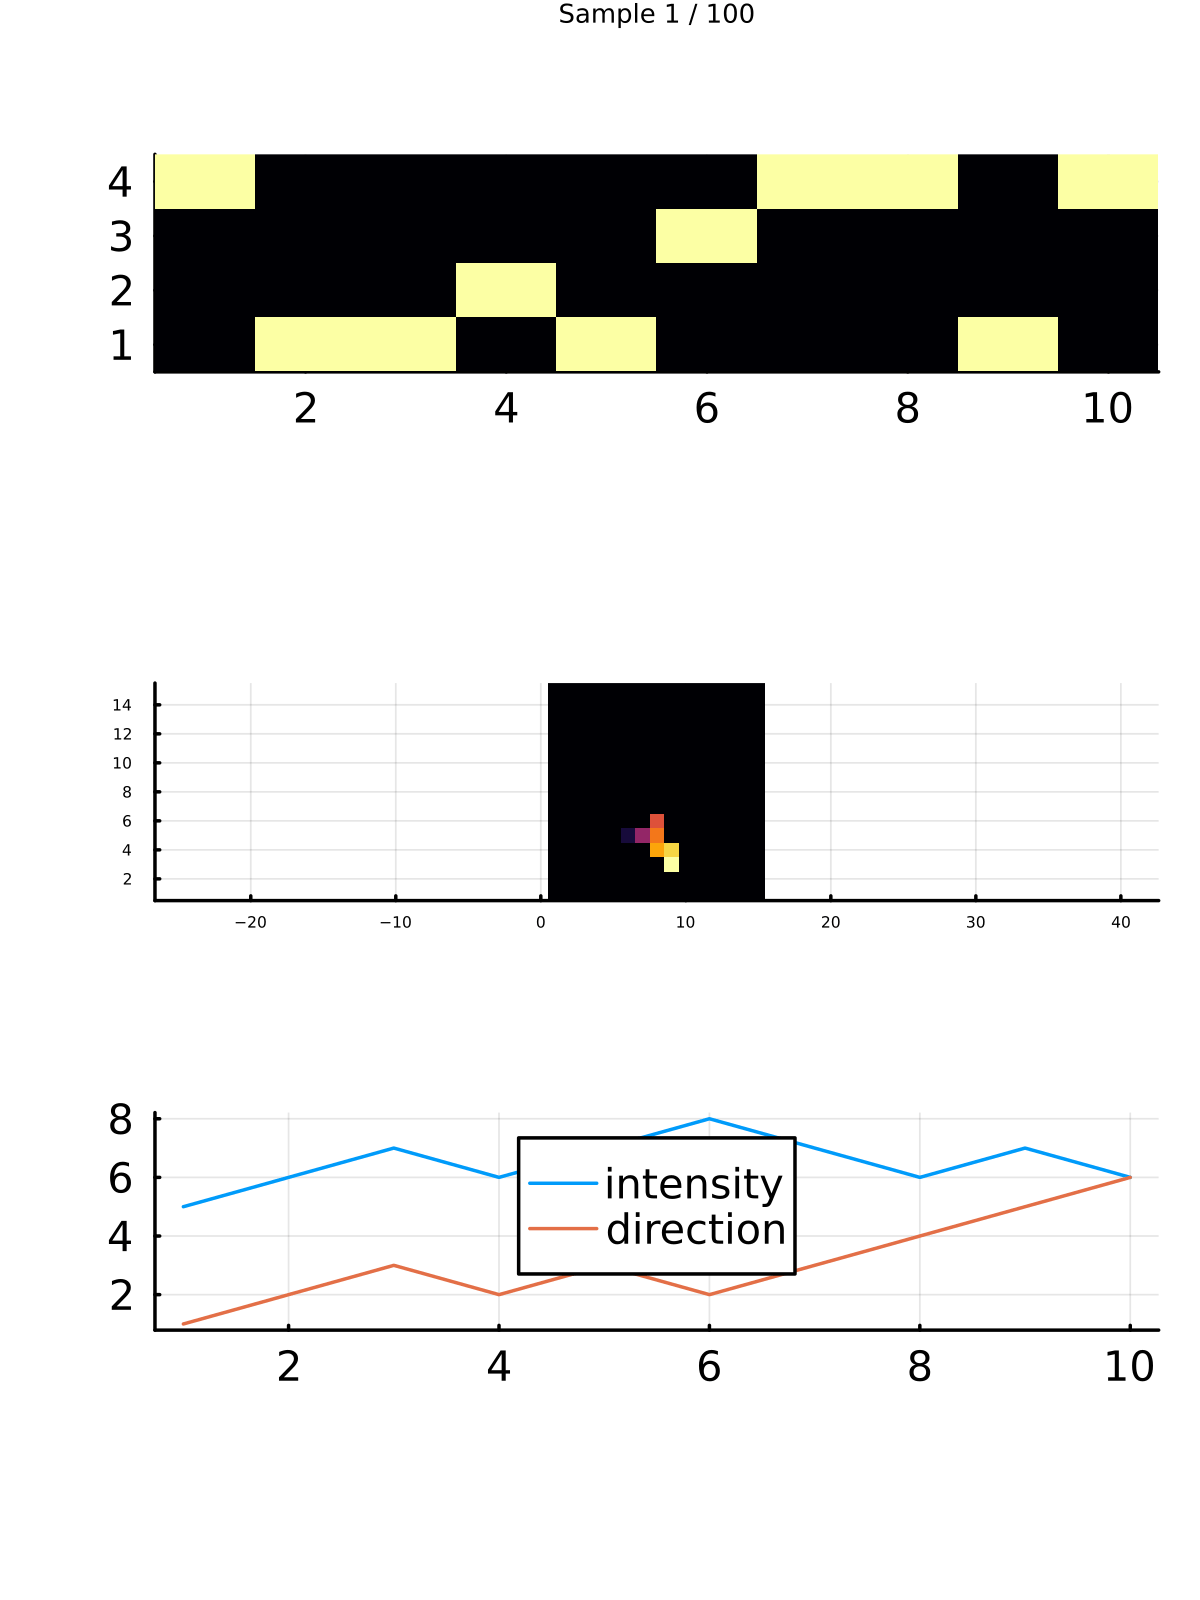

In [33]:
viz = Plots.@animate for (trace_id, trace) in enumerate(pf_traces)
    visualize(trace;title="Sample $trace_id / 100")
end
gif(viz, fps=1)

From the animation, we notice the posterior distribution is mostly composed of two trajectories that appear as mirrors of each other. From this observation, we draw the conclusion that there are two probable trajectories of the turtle. In our computation of intensity and direction, the return values are not dependent on x and y individually, meaning that if we were to swap the values of x and y, we could get the same intensity and direction. This explains why we see two probable trajectories, which, based on the "swap theory", are equally likely. 